<a href="https://colab.research.google.com/github/raissDataScience/App_DatabaseSQL_Flask/blob/main/TER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd TER

/content/TER


In [2]:
ls

In [3]:
!git clone https://github.com/XiSHEN0220/SegSwap.git

Cloning into 'SegSwap'...
remote: Enumerating objects: 1695, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 1695 (delta 10), reused 14 (delta 5), pack-reused 1671
Receiving objects: 100% (1695/1695), 1.65 GiB | 15.56 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Checking out files: 100% (1672/1672), done.


In [4]:
cd ./SegSwap

/content/TER/SegSwap


In [ ]:
#cd ../../SegSwap

/content/TER/SegSwap


In [5]:
ls

data/  evalBrueghel/  evalPitts/  fig/     model/     requirement.sh
demo/  evalInt/       evalTokyo/  LICENSE  README.md  train/


In [6]:
cd ./model

/content/TER/SegSwap/model


In [7]:
ls

convert_torchvision.py  download_model.sh  hard_mining_neg5.pth  transformer.py


In [8]:
# coding=utf-8
import os 
import sys 
sys.path.append('../model')
import numpy as np 
from PIL import Image

import torch 
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

import transformer # model

def consistent_mask(m1, m2, o1, o2) : 
    '''
    Produce masks that are cycle-consistent with flow
    
    Input: masks (m1 and m2) and flows (o1 and o2) predicted for both images 
    Output: masks that are cycle-consistent with flow prediction (m1_final, m2_final)
    '''
    flow12 = (o1.narrow(0, 0, 2).unsqueeze(0).permute(0, 2, 3, 1) - 0.5) * 2 
    flow21 = (o2.narrow(0, 0, 2).unsqueeze(0).permute(0, 2, 3, 1) - 0.5) * 2 
    

    m1_warp = F.grid_sample(torch.from_numpy(m1.astype(np.float32)).unsqueeze(0).unsqueeze(0), flow21, mode='bilinear').numpy().squeeze()
    m2_consist = m1_warp  * m2

    m1_back = F.grid_sample(torch.from_numpy(m2_consist.astype(np.float32)).unsqueeze(0).unsqueeze(0), flow12, mode='bilinear')
    m1_final  = (m1 * m1_back.squeeze().numpy() )

    m2_final = F.grid_sample(torch.from_numpy(m1_final.astype(np.float32)).unsqueeze(0).unsqueeze(0), flow21, mode='bilinear')
    m2_final = (m2 * m2_final.squeeze().numpy() )
    return m1_final, m2_final

def resize(I, img_size, stride=16) : 
    '''
    Resize images 
    1. Each dimension can be divided by stride (16)
    2. largest dimension is defined by img_size
    3. keeping aspect ratio
    
    Input: masks (m1 and m2) and flows (o1 and o2) predicted for both images 
    Output: masks that are cycle-consistent with flow prediction (m1_final, m2_final)
    '''
    w, h = I.size
    ratio = max(1.0 * w / img_size, 1.0 * h / img_size)
    
    new_w = int(round(w / ratio / stride)) * stride
    new_h = int(round(h / ratio / stride)) * stride
    return I.resize((new_w, new_h), resample=2)

In [9]:
## set gpu
device = torch.device('cuda')

## load Moco feature
backbone = models.resnet50(pretrained=False)   
resnet_feature_layers = ['conv1','bn1','relu','maxpool','layer1','layer2','layer3']
resnet_module_list = [getattr(backbone,l) for l in resnet_feature_layers]
last_layer_idx = resnet_feature_layers.index('layer3')
backbone = torch.nn.Sequential(*resnet_module_list[:last_layer_idx+1])

## load pre-trained weight
resume_path_segswap= '../model/hard_mining_neg5.pth'
pos_weight = 0.1
feat_weight = 1
dropout = 0.1
activation = 'relu'
mode = 'small'
layer_type = ['I', 'C', 'I', 'C', 'I', 'N']
drop_feat = 0.1
feat_dim=1024

## model
netEncoder = transformer.TransEncoder(feat_dim,
                                      pos_weight = pos_weight,
                                      feat_weight = feat_weight,
                                      dropout= dropout,
                                      activation=activation,
                                      mode=mode,
                                      layer_type = layer_type,
                                      drop_feat = drop_feat) 

netEncoder.cuda()

print ('Loading net weight from {}'.format(resume_path_segswap))
param = torch.load(resume_path_segswap)
backbone.load_state_dict(param['backbone'])
netEncoder.load_state_dict(param['encoder'])
backbone.eval()
netEncoder.eval()
backbone.cuda()
netEncoder.cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading net weight from ../model/hard_mining_neg5.pth


TransEncoder(
  (net): Encoder(
    (feat_proj): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (drop_feat): Dropout2d(p=0.1, inplace=False)
    (encoder_blocks): ModuleList(
      (0): EncoderLayerBlock(
        (layer1): EncoderLayerInnerAttention(
          (inner_encoder_layer): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=256, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
          (posEncoder): PositionEncodingSin

In [10]:
img_dir = '../data/Brueghel/Image/'
image2 = 'Paradise_with_Fall_of_Man__Brentford_.png'
image1 = 'Paradise_Landscape_with_Noah_s_Ark__Los_Angeles__J._Paul_Getty_Museum_.png'
img_size = 1120
I1 = Image.open(os.path.join(img_dir, image1)).convert('RGB')
I2 = Image.open(os.path.join(img_dir, image2)).convert('RGB')

In [11]:
norm_mean, norm_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
transformINet = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])
tensor1 = resize(I1, img_size)
tensor2 = resize(I2, img_size)


tensor1 = transformINet(tensor1).unsqueeze(0).cuda()
tensor2 = transformINet(tensor2).unsqueeze(0).cuda()


with torch.no_grad() : 
    feat1 = backbone( tensor1 ) ## features
    feat1 = F.normalize(feat1) ## l2 normalization
    feat2 = backbone( tensor2 ) ## features 
    feat2 = F.normalize(feat2) ## l2 normalization
    out1, out2 = netEncoder(feat1, feat2) ## predictions
    m1_final, m2_final = consistent_mask(out1[0, 2].cpu().numpy(), out2[0, 2].cpu().numpy(), out1[0].cpu(), out2[0].cpu())

/content/TER/SegSwap/model/transformer.py:43: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


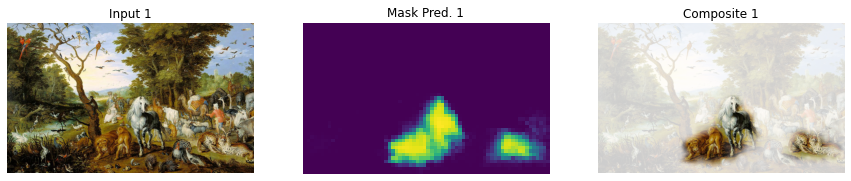

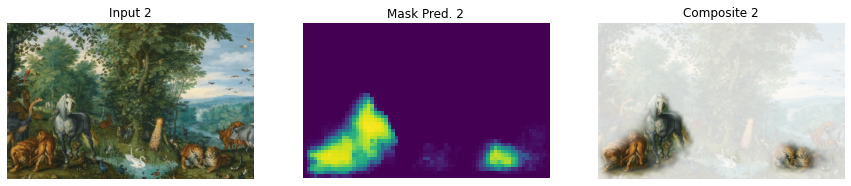

In [12]:
import matplotlib.pyplot as plt 
%matplotlib inline 


arr1 = np.array(I1)
m1_up = F.interpolate(torch.from_numpy(m1_final.astype(np.float32)).unsqueeze(0).unsqueeze(0), size=(arr1.shape[0], arr1.shape[1]), mode='bilinear').numpy().squeeze()
m1_up = np.clip(m1_up * 255 + 50, a_min=50, a_max=255)
m1_up = m1_up.astype(np.uint8).reshape(arr1.shape[0], arr1.shape[1], 1)
arr1_mask = np.concatenate((arr1, m1_up), axis=2)
Image.fromarray(arr1_mask).save('I1_mask_swap.png')
I1.save('I1_org.png')
np.save('m1_final.npy', m1_final)

arr2 = np.array(I2)
m2_up = F.interpolate(torch.from_numpy(m2_final.astype(np.float32)).unsqueeze(0).unsqueeze(0), size=(arr2.shape[0], arr2.shape[1]), mode='bilinear').numpy().squeeze()
m2_up = np.clip(m2_up * 255 + 50, a_min=50, a_max=255)
m2_up = m2_up.astype(np.uint8).reshape(arr2.shape[0], arr2.shape[1], 1)
arr2_mask = np.concatenate((arr2, m2_up), axis=2)
Image.fromarray(arr2_mask).save('I2_mask_segswap.png')
I2.save('I2_org.png')
np.save('m2_final.npy', m2_final)



f = plt.figure(figsize=(15, 32))
f.add_subplot(1, 3, 1)
plt.imshow(I1)
plt.axis('off')
plt.title("Input 1")

f.add_subplot(1, 3, 2)
plt.imshow(m1_final)
plt.axis('off')
plt.title("Mask Pred. 1")

f.add_subplot(1, 3, 3)
plt.imshow(arr1_mask)
plt.axis('off')
plt.title("Composite 1")
plt.show()

f = plt.figure(figsize=(15, 32))
f.add_subplot(1, 3, 1)
plt.imshow(I2)
plt.axis('off')
plt.title("Input 2")

f.add_subplot(1, 3, 2)
plt.imshow(m2_final)
plt.axis('off')
plt.title("Mask Pred. 2")

f.add_subplot(1, 3, 3)
plt.imshow(arr2_mask)
plt.axis('off')
plt.title("Composite 2")
plt.show()

In [13]:
cd ../../SegSwap

/content/TER/SegSwap


In [14]:
ls

data/  evalBrueghel/  evalPitts/  fig/     model/     requirement.sh
demo/  evalInt/       evalTokyo/  LICENSE  README.md  train/


In [15]:
!pip install tqdm
!pip install opencv-python==4.5.2
!pip install scipy==1.5.4
!pip install torch==1.7.1
!pip install torchvision==0.8.2
!pip install kornia==0.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement opencv-python==4.5.2 (from versions: 3.4.0.14, 3.4.2.17, 3.4.3.18, 3.4.4.19, 3.4.5.20, 3.4.6.27, 3.4.7.28, 3.4.8.29, 3.4.9.31, 3.4.9.33, 3.4.10.35, 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.14.51, 3.4.14.53, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.0.0.21, 4.0.1.23, 4.0.1.24, 4.1.0.25, 4.1.1.26, 4.1.2.30, 4.2.0.32, 4.2.0.34, 4.3.0.36, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.2.52, 4.5.2.54, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66)
ERROR: No matching distribution found for opencv-python==4.5.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.9 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 14.5 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 271 kB 36.5 MB/s 


In [16]:
#cd ../../SegSwap

[Errno 2] No such file or directory: '../../SegSwap'
/content/TER/SegSwap


In [17]:
cd ./model

/content/TER/SegSwap/model


In [19]:
ls

convert_torchvision.py  I1_mask_swap.png     I2_org.png    __pycache__/
download_model.sh       I1_org.png           m1_final.npy  transformer.py
hard_mining_neg5.pth    I2_mask_segswap.png  m2_final.npy


In [20]:
cd ./pretrained

/content/TER/SegSwap/model/pretrained


In [23]:
!bash download_model.sh

--2022-11-27 18:15:21--  https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112133139 (107M) [application/octet-stream]
Saving to: ‘moco_v2_800ep_pretrain.pth.tar’

moco_v2_800ep_pretr 100%[===================>] 106.94M  18.0MB/s    in 7.5s    

2022-11-27 18:15:30 (14.2 MB/s) - ‘moco_v2_800ep_pretrain.pth.tar’ saved [112133139/112133139]

module.encoder_q.conv1.weight -> conv1.weight
module.encoder_q.bn1.weight -> bn1.weight
module.encoder_q.bn1.bias -> bn1.bias
module.encoder_q.bn1.running_mean -> bn1.running_mean
module.encoder_q.bn1.running_var -> bn1.running_var
module.encoder_q.bn1.num_batches_tracked -> bn1.num_batches_tracked
module.encoder_q.layer1.0.conv1.weight -> layer1.0.con

In [24]:
cd ../../data

/content/TER/SegSwap/data


In [25]:
ls

AdaIn/                       COCO2017_train_obj.json  Internet/
Brueghel/                    file2web1obj.py          style_transfer.py
COCO2017/                    file2web2obj.py          utils.py
COCO2017_train_img2cat.json  generate_1obj.py         vis_pair.sh
COCO2017_train_img2obj.json  generate_2obj.py


In [26]:
cd ./COCO2017

/content/TER/SegSwap/data/COCO2017


In [27]:
ls

download_coco.sh


In [28]:
!bash download_coco.sh

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
 extracting: train2017/000000259556.jpg  
 extracting: train2017/000000381931.jpg  
 extracting: train2017/000000569592.jpg  
 extracting: train2017/000000229396.jpg  
 extracting: train2017/000000488990.jpg  
 extracting: train2017/000000348684.jpg  
 extracting: train2017/000000234031.jpg  
 extracting: train2017/000000563584.jpg  
 extracting: train2017/000000276069.jpg  
 extracting: train2017/000000401194.jpg  
 extracting: train2017/000000502089.jpg  
 extracting: train2017/000000192183.jpg  
 extracting: train2017/000000425127.jpg  
 extracting: train2017/000000126766.jpg  
 extracting: train2017/000000324161.jpg  
 extracting: train2017/000000452746.jpg  
 extracting: train2017/000000423782.jpg  
 extracting: train2017/000000546343.jpg  
 extracting: train2017/000000249290.jpg  
 extracting: train2017/000000025529.jpg  
 extracting: train2017/000000316928.jpg  
 extracting: train2017/000000337866.jpg 

In [29]:
ls

annotations/  download_coco.sh  train2017/


In [30]:
cd ../../data

/content/TER/SegSwap/data


In [31]:
ls

AdaIn/                       COCO2017_train_obj.json  Internet/
Brueghel/                    file2web1obj.py          style_transfer.py
COCO2017/                    file2web2obj.py          utils.py
COCO2017_train_img2cat.json  generate_1obj.py         vis_pair.sh
COCO2017_train_img2obj.json  generate_2obj.py


In [32]:
!python generate_1obj.py --out-dir pairs_1obj_100k 

Namespace(angle_max=15, angle_min=-15, ar_scale_min=0.7, coco_dir='COCO2017/train2017/', decoder_pth='AdaIn/Adain_decoder_iter160K.pth.tar', end_idx=50, gpu='0', img_size=[480, 480], info_json='COCO2017_train_img2cat.json', iter_dilation=20, obj_json='COCO2017_train_obj.json', obj_scale_bg_max=1, obj_scale_bg_min=0.2, out_dir='pairs_1obj_100k', start_idx=0, style_dir='Brueghel/Image/', vgg_pth='AdaIn/vgg_normalised.pth')
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the o

Pour les paires des objets

In [35]:
#!python generate_2obj.py --out-dir pairs_2obj_100k 

Namespace(angle_max=15, angle_min=-15, ar_scale_max=1.0, ar_scale_min=0.7, coco_dir='COCO2017/train2017/', decoder_pth='AdaIn/Adain_decoder_iter160K.pth.tar', end_idx=50, gpu='2', img2obj_json='COCO2017_train_img2obj.json', img_size=480, info_json='COCO2017_train_img2cat.json', iter_dilation=20, obj_json='COCO2017_train_obj.json', obj_scale_bg_max=1, obj_scale_bg_min=0.5, out_dir='pairs_2obj_100k', start_idx=0, style_dir='Brueghel/Image/', vgg_pth='AdaIn/vgg_normalised.pth')
Traceback (most recent call last):
  File "generate_2obj.py", line 309, in <module>
    vgg.to(device)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 612, in to
    return self._apply(convert)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 359, in _apply
    module._apply(fn)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 381, in _apply
    param_applied = fn(param)
  File "/usr/local/lib/python3.7/dist-packages/to

AFFICHAGE

In [38]:
!bash vis_pair.sh

Namespace(angle_max=15, angle_min=-15, ar_scale_min=0.7, coco_dir='COCO2017/train2017/', decoder_pth='AdaIn/Adain_decoder_iter160K.pth.tar', end_idx=10, gpu='0', img_size=[480, 480], info_json='COCO2017_train_img2cat.json', iter_dilation=20, obj_json='COCO2017_train_obj.json', obj_scale_bg_max=1, obj_scale_bg_min=0.2, out_dir='vis10_1obj/', start_idx=0, style_dir='Brueghel/Image/', vgg_pth='AdaIn/vgg_normalised.pth')
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old b

In [ ]:
!vis10_1obj/vis.html

In [ ]:
#!vis10_2obj/vis.html